# Iterative Method for Barycenter Computation


In [80]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F

from scipy.stats import ortho_group
from scipy.linalg import sqrtm

from src.icnn import DenseICNN_U
from src.plotters import plot_training_phase
from src.tools import ewma, score_gen, freeze, unfreeze
from src.fid_score import calculate_frechet_distance
from src import distributions
from src import bar_benchmark
import itertools

import gc
from sklearn.decomposition import PCA

from copy import deepcopy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import sys
import os

# Get the parent folder path (folder K)
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

print(parent_folder)

# Add folder A to the Python path
folder_classes_path = os.path.join(parent_folder, 'classes')
sys.path.append(folder_classes_path)

from input_generate_entropy import *
from true_WB import *

/Users/zeyichen/GitHub/Repo/WB_Algo/Exp1_WBverify


## Config

In [82]:
DIM = 2
assert DIM > 1

GPU_DEVICE = 2
BATCH_SIZE = 1024

LAMBDA = 10
G_LR = 1e-4
D_LR = 1e-3
MAX_ITER = 10001

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

PLOT_FREQ = 499
SCORE_FREQ = 499

# Parameters for input distributions
NUM = 3
ALPHAS = np.array([1. / NUM for _ in range(NUM)])

CASE = {
    'type' : 'EigWarp', 
    'sampler' : 'Rectangles', #'Gaussians', #'SwissRoll',# , #
    'params' : {'num' : NUM, 'alphas' : ALPHAS, 'min_eig' : .5, 'max_eig' : 2}
}


OUTPUT_SEED = 0xBADBEEF

In [83]:
# assert torch.cuda.is_available()
# torch.cuda.set_device(GPU_DEVICE)

# np.random.seed(OUTPUT_SEED)
# torch.manual_seed(OUTPUT_SEED)

## Initializing distributions

In [84]:
# if CASE['type'] == 'EigWarp':
#     if CASE['sampler'] == 'Gaussians':
#         sampler = distributions.StandardNormalSampler(dim=DIM)
#     elif CASE['sampler'] == 'SwissRoll':
#         assert DIM == 2
#         sampler = distributions.SwissRollSampler()
#     elif CASE['sampler'] == 'Rectangles':
#         sampler = distributions.CubeUniformSampler(dim=DIM, normalized=True, centered=True)
    
#     benchmark = bar_benchmark.EigenWarpBenchmark(sampler, **CASE['params'])

In [85]:
num_measures = 3

## Discriminators Setup

In [86]:
D = nn.Sequential(
    nn.Linear(DIM, max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), 1)
).cpu()

T = nn.Sequential(
    nn.Linear(DIM, max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), DIM)
).cpu()

In [87]:
# Ds = nn.ModuleList([deepcopy(D) for _ in range(benchmark.num)]).cpu()
# Ts = nn.ModuleList([deepcopy(T) for _ in range(benchmark.num)]).cpu()

# Ds_inv = nn.ModuleList([deepcopy(D) for _ in range(benchmark.num)]).cpu()
# Ts_inv = nn.ModuleList([deepcopy(T) for _ in range(benchmark.num)]).cpu()

Ds = nn.ModuleList([deepcopy(D) for _ in range(num_measures)]).cpu()
Ts = nn.ModuleList([deepcopy(T) for _ in range(num_measures)]).cpu()

Ds_inv = nn.ModuleList([deepcopy(D) for _ in range(num_measures)]).cpu()
Ts_inv = nn.ModuleList([deepcopy(T) for _ in range(num_measures)]).cpu()

## Generator Setup

In [88]:
# For now DIM_Z = DIM_X
Z_sampler = distributions.StandardNormalSampler(dim=DIM)

In [89]:
G = nn.Sequential(
    nn.Linear(DIM, max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Dropout(0.005),
    nn.Linear(max(100, 2*DIM), max(100, 2*DIM)),
    nn.ReLU(True),
    nn.Linear(max(100, 2*DIM), DIM)
)

In [90]:
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
loss = np.inf

G.train(True)

for iteration in tqdm_notebook(range(10000)):
    Z = Z_sampler.sample(BATCH_SIZE).detach() * 3
    loss = F.mse_loss(Z, G(Z))
    loss.backward()
    G_opt.step(); G_opt.zero_grad()
    if loss.item() < 1e-2:
        break

print(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(0.0099, grad_fn=<MseLossBackward0>)


## PCA

In [91]:
pca = PCA(n_components=2)

class Identity:
    pass

# if benchmark.bar_sampler is not None:
#     pca.fit(benchmark.bar_sampler.sample(100000).cpu().detach().numpy())
# elif benchmark.gauss_bar_sampler is not None:
#     pca.fit(benchmark.gauss_bar_sampler.sample(100000).cpu().detach().numpy())
# else:
#     pca = Identity()
#     pca.transform = lambda x: x
    
# No PCA for dim=2
if DIM == 2:
    pca = Identity()
    pca.transform = lambda x: x

## Main training

In [92]:
G_opt = torch.optim.Adam(G.parameters(), lr=G_LR, weight_decay=1e-10)
Ts_opt, Ds_opt = [], []
Ts_inv_opt, Ds_inv_opt = [], []
# for k in range(benchmark.num):
#     Ts_opt.append(torch.optim.Adam(Ts[k].parameters(), lr=D_LR, weight_decay=1e-10))
#     Ds_opt.append(torch.optim.Adam(Ds[k].parameters(), lr=D_LR, weight_decay=1e-10))
#     Ts_inv_opt.append(torch.optim.Adam(Ts_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))
#     Ds_inv_opt.append(torch.optim.Adam(Ds_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))

for k in range(num_measures):
    Ts_opt.append(torch.optim.Adam(Ts[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ds_opt.append(torch.optim.Adam(Ds[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ts_inv_opt.append(torch.optim.Adam(Ts_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))
    Ds_inv_opt.append(torch.optim.Adam(Ds_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))

In [93]:
G_loss_history = []

G_UVP_history = []

# if hasattr(benchmark, 'gauss_bar_cost'):
#     print('Gaussian Barycenter Cost:', benchmark.gauss_bar_cost)

In [94]:
it = 0
last_plot_it = -1
last_score_it = -1

In [95]:
source_sampler = MixtureOfGaussians(DIM)
source_sampler.random_components(5)
source_sampler.set_truncation(100)
entropic_sampler = entropic_input_sampler(2, 3, 2, source_sampler, n_k = 10)

entropic_sampler.construct_surjective_mapping()
entropic_sampler.generate_strong_convexity_param()
entropic_sampler.generate_g_vectors()
entropic_sampler.generate_Y_matrices()
entropic_sampler.compute_theta()

In [96]:
# # test
# MAX_ITER = 10
# D_ITERS = 2
# T_ITERS = 2
# G_ITERS = 2
# BATCH_SIZE = 1024

In [2]:
# network save
NN_save_path = "NN_save"

In [97]:
while it < MAX_ITER:
    freeze(G)
    input_measure_samples_for_D = entropic_sampler.sample(BATCH_SIZE * D_ITERS)
    input_measure_samples_for_T_inv = entropic_sampler.sample(BATCH_SIZE * D_ITERS * T_ITERS)
    input_measure_samples_for_D_inv = entropic_sampler.sample(BATCH_SIZE * D_ITERS)
    # this is a dictionary with k keys, pointing to the samples collected from each measure
    for k in range(num_measures):
        # D and T optimization cycle
        for d_iter in tqdm(range(D_ITERS)):
            it += 1

            # T optimization
            unfreeze(Ts[k]); freeze(Ds[k])
            for t_iter in range(T_ITERS): 
                with torch.no_grad():
                    X = G(Z_sampler.sample(BATCH_SIZE))
                Ts_opt[k].zero_grad()
                T_X = Ts[k](X)
                T_loss = F.mse_loss(X, T_X).mean() - Ds[k](T_X).mean()
                T_loss.backward(); Ts_opt[k].step()
            del T_loss, T_X, X
            gc.collect()

            # D optimization
            with torch.no_grad():
                X = G(Z_sampler.sample(BATCH_SIZE))
            # Y = benchmark.samplers[k].sample(BATCH_SIZE)
            Y = torch.tensor(input_measure_samples_for_D[k][d_iter * BATCH_SIZE : (d_iter + 1) * BATCH_SIZE]).float()
            
            unfreeze(Ds[k]); freeze(Ts[k])
            T_X = Ts[k](X).detach()
            Ds_opt[k].zero_grad()
            D_loss = Ds[k](T_X).mean() - Ds[k](Y).mean()
            D_loss.backward(); Ds_opt[k].step()
            del D_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
            
            # T inv optimization
            unfreeze(Ts_inv[k]); freeze(Ds_inv[k])
            for t_iter in range(T_ITERS): 
                Y = torch.tensor(input_measure_samples_for_T_inv[k][d_iter * T_ITERS * BATCH_SIZE + t_iter * BATCH_SIZE : d_iter * T_ITERS * BATCH_SIZE + (t_iter + 1) * BATCH_SIZE]).float()
                Ts_inv_opt[k].zero_grad()
                T_inv_Y = Ts_inv[k](Y)
                T_inv_loss = F.mse_loss(Y, T_inv_Y).mean() - Ds_inv[k](T_inv_Y).mean()
                T_inv_loss.backward(); Ts_inv_opt[k].step()
            del T_inv_loss, T_inv_Y, Y; gc.collect(); torch.cuda.empty_cache()

            # D inv optimization
            Y = torch.tensor(input_measure_samples_for_D_inv[k][d_iter * BATCH_SIZE : (d_iter + 1) * BATCH_SIZE]).float()
            with torch.no_grad():
                X = G(Z_sampler.sample(BATCH_SIZE))
            
            unfreeze(Ds_inv[k]); freeze(Ts_inv[k])
            T_inv_Y = Ts_inv[k](Y).detach()
            Ds_inv_opt[k].zero_grad()
            D_inv_loss = Ds_inv[k](T_inv_Y).mean() - Ds_inv[k](X).mean()
            D_inv_loss.backward(); Ds_inv_opt[k].step()
            del D_inv_loss, Y, X, T_inv_Y; gc.collect(); torch.cuda.empty_cache()
    
    # # Scoring
    # if it - last_score_it >= SCORE_FREQ:
    #     last_score_it = it
    #     if benchmark.gauss_bar_sampler is not None:
    #         G_UVP = score_gen(benchmark, G, Z_sampler, score_size=100000)
    #         G_UVP_history.append(G_UVP)
    
    # # Plotting
    # if it - last_plot_it >= PLOT_FREQ:
    #     clear_output(wait=True)
    #     print('Iteration', it)
    #     last_plot_it = it        
        
    #     # Plotting Metrics
    #     fig, axes = plt.subplots(1, 3, figsize=(15, 3), dpi=200)
        
    #     axes[0].set_title('G Loss (Regression), log10', fontsize=12)
    #     axes[0].set_xlabel('Iteration', fontsize=11)
    #     axes[0].plot(np.log10(ewma(G_loss_history, span=10)))
        
    #     axes[1].set_title('UVP loss', fontsize=12)
    #     axes[1].set_xlabel('Iteration', fontsize=11)
    #     axes[1].plot(ewma(G_UVP_history, span=20), label='Gen BW')
    #     axes[1].legend()
        
    #     print('G-UVP: {}%'.format(np.mean(G_UVP_history[-10:])))
        
    #     fig.tight_layout(); plt.show(); plt.close(fig)
        
    #     # Plotting scatter plots
    #     fig, ax = plot_training_phase(benchmark, pca, Ts, Ts_inv, G, Z_sampler)
    #     fig.tight_layout()
    #     plt.show()
    #     plt.close(fig)
        
    # G optimization
    if G_ITERS > 0:
        for k in range(num_measures):
            freeze(Ts[k])
        G_old = deepcopy(G); freeze(G_old)
        unfreeze(G)
        for g_iter in range(G_ITERS):
            it += 1
            Z = Z_sampler.sample(BATCH_SIZE)
            with torch.no_grad():
                G_old_Z = G_old(Z)
                T_G_old_Z = torch.zeros_like(G_old(Z))
            G_old_Z.requires_grad_(True)
            for k in range(num_measures):
                T_G_old_Z += ALPHAS[k] * Ts[k](G_old_Z)

            G_opt.zero_grad()
            G_loss = .5 * F.mse_loss(G(Z), T_G_old_Z)
            G_loss.backward(); G_opt.step() 

            G_loss_history.append(G_loss.item())

        save_path = f"{NN_save_path}/trained_models_iter_{it}"
        os.makedirs(save_path, exist_ok=True)
        models_to_save = {
            "G": G.state_dict(),
            "Ts": {k: Ts[k].state_dict() for k in range(num_measures)},
            "Ds": {k: Ds[k].state_dict() for k in range(num_measures)},
            # Save the inverse transforms if needed
            "Ts_inv": {k: Ts_inv[k].state_dict() for k in range(num_measures)},
            "Ds_inv": {k: Ds_inv[k].state_dict() for k in range(num_measures)},
        }

        # Save the dictionary
        torch.save(models_to_save, save_path)
        print(f"Models saved to {save_path}")

            # Log G_loss_history to a local file
        with open("G_loss_history.log", "a") as f:
            f.write(f"Iteration {it}, G_loss: {G_loss.item()}\n")

        del G_old, G_loss, T_G_old_Z, Z
        gc.collect()

100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


In [100]:
### save the model (all parameters)
# Save all trained parameters after training
save_path = "trained_models.pth"

# Collect all models into a dictionary
models_to_save = {
    "G": G.state_dict(),
    "Ts": {k: Ts[k].state_dict() for k in range(num_measures)},
    "Ds": {k: Ds[k].state_dict() for k in range(num_measures)},
    # Save the inverse transforms if needed
    "Ts_inv": {k: Ts_inv[k].state_dict() for k in range(num_measures)},
    "Ds_inv": {k: Ds_inv[k].state_dict() for k in range(num_measures)},
}

# Save the dictionary
torch.save(models_to_save, save_path)
print(f"Models saved to {save_path}")


Models saved to trained_models.pth


In [109]:
import ot
import ot.plot

WB_samples = source_sampler.sample(1000)
WB_approximate_samples = G(Z_sampler.sample(1000)).cpu().detach().numpy() * 3

M = ot.dist(WB_samples, WB_approximate_samples)
a, b = np.ones((WB_samples.shape[0],)) / WB_samples.shape[0], np.ones((WB_approximate_samples.shape[0],)) / WB_approximate_samples.shape[0]
W2_sq = ot.emd2(a, b, M, numItermax=1e6)

print(f"Wasserstein distance between true and approximated Wasserstein barycenter: {W2_sq}")


source sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Wasserstein distance between true and approximated Wasserstein barycenter: 17.198206089000607


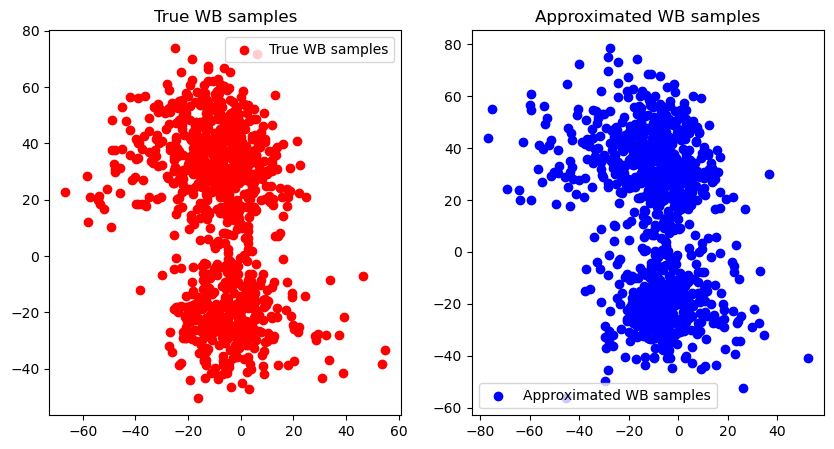

In [110]:
# plot WB_samples and WB_approximate_samples together 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.scatter(WB_samples[:, 0], WB_samples[:, 1], c='r', label='True WB samples')
ax.set_title("True WB samples")
ax.legend()

ax = fig.add_subplot(122)
ax.scatter(WB_approximate_samples[:, 0], WB_approximate_samples[:, 1], c='b', label='Approximated WB samples')
ax.set_title("Approximated WB samples")
ax.legend()

plt.show()
plt.close(fig)


source sampling:   0%|          | 0/1000 [00:00<?, ?it/s]


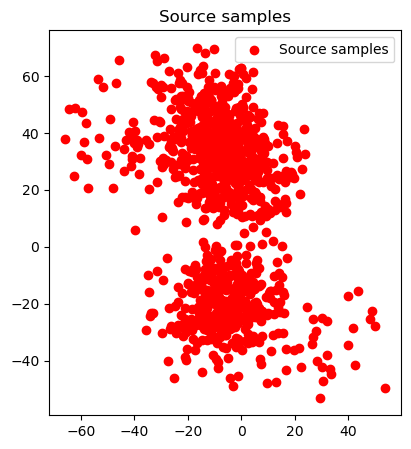

In [108]:
# collect another set of samples from the source distribution
source_samples = source_sampler.sample(1000)

# plot

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.scatter(source_samples[:, 0], source_samples[:, 1], c='r', label='Source samples')
ax.set_title("Source samples")
ax.legend()

plt.show()


In [ ]:
input_measure_samples = entropic_sampler.sample(1000)